# Game market analysis

In this project we will make an analysis of world's game market: trace all the possible correlations and will make an average portrait of market depending on different regions. 2nd task will be to perform A/B tests for users score between some platfoms and genres.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
from scipy import stats as st

## Import data

In [2]:
df = pd.read_csv('/datasets/games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
#change all the column names to the lower case.
df.columns = df.columns.str.lower()

In [4]:
#check the main info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


We see missing values in  `name`, `year_of_release`, `genre`, `critic_score`, `user_score` and `rating`.
Type of `year_of_release` should be changed, because year has integer value.
Also we need to check `user_score`, it should contain numerical values. 

In [5]:
# check the duplicates
df.duplicated().sum()

0

### Data preprocessing.

In [6]:
#count % of missing  values and drop all the small ammount of missing data
for col in df.columns:
    pct_missing = np.mean(df[col].isna())
    if round(pct_missing*100,2) <= 2:
        df = df.dropna(subset=[col])
    else:
        print('{} - {}%'.format(col, round(pct_missing*100,2)))
#    pct_missing = np.mean(df[col].isna())
#    print('{} - {}%'.format(col, round(pct_missing*100,2)))

critic_score - 51.45%
user_score - 40.17%
rating - 40.6%


#### User score.

As the type in this column is `object`, let's check the values.

In [7]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

TBD - to be discussed/determined. Replace these values with *None*

In [8]:
df['user_score'] = df['user_score'].replace('tbd', None)
df['user_score'] = df['user_score'].astype('float64')

#### Rating.

Check if there are any values that are not related to the rating.

In [9]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

EC — Early Childhood

E — Everyone

E10+ — Everyone 10+

T — Teen

M — Mature

AO — Adults Only

RP — Rating Pending

K-A — Kids to Aduldts


Replace missing values with *Unknown*

In [10]:
df['rating'] = np.where((df['rating'].isna()), 'unknown', df.rating)

#### Sum of sales over all regions.

Make a separate column for sum of sales over all regions.

In [11]:
df['total_sales'] = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


## Data analysis

### Count the number of games per each year

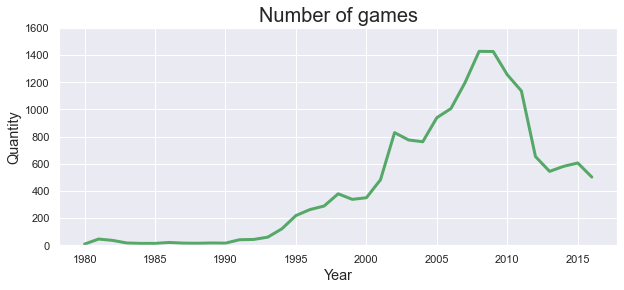

In [12]:
year_count = df.groupby(by='year_of_release')['name'].count()
plt.figure(figsize=(10,4))
plt.title('Number of games', fontsize=20)
plt.plot(year_count, linewidth=3.0, color='g')
plt.ylim(0,1600)
plt.xlabel('Year', fontsize='large')
plt.ylabel('Quantity', fontsize='large')
plt.grid(True)
plt.show()

We see some main periods:

1) From 1980 to 1993 - the beginning. Number of new games per year is less than 100;

2) Jump to 400 games by 1998;

3) Rapid jump to 800 till 2002;

4) Last jump till the peak in 2008-2009;

5) Reducing to 500-600 from 2012 till 2016.

Most possible the rapid jump is caused by multiple number of new platforms.

### Sales

Let's analyse how sales have been distributed between platforms.

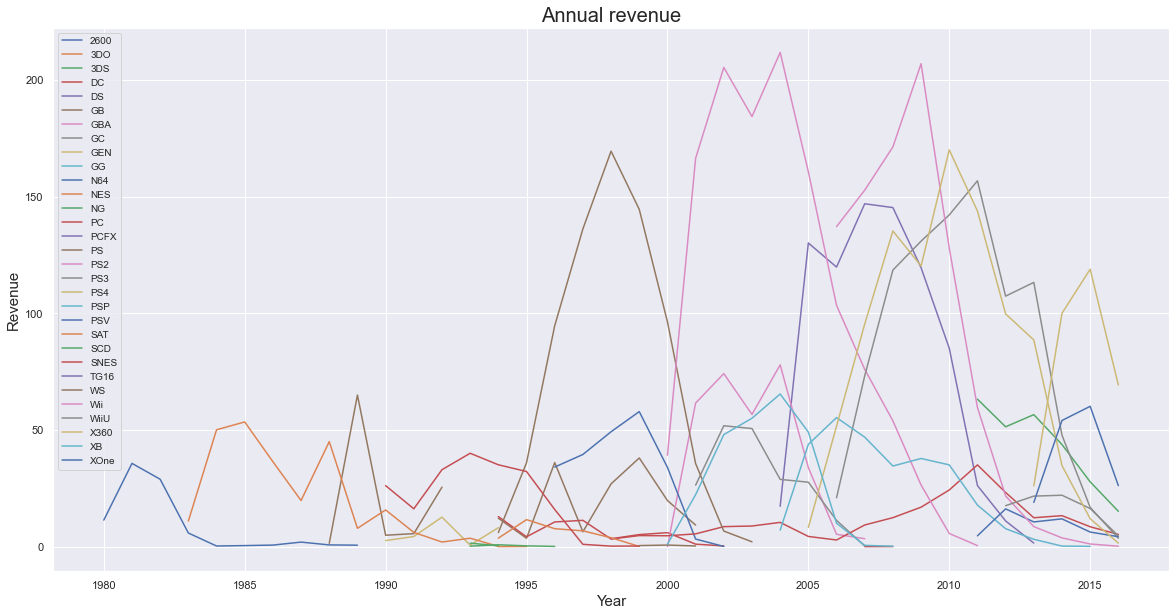

In [13]:
plat_year = df.pivot_table(index='year_of_release', columns='platform',
values='total_sales', aggfunc='sum')
plt.figure(figsize=(20,10))
plt.plot(plat_year)
plt.title('Annual revenue', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Revenue', fontsize=15)
plt.legend(plat_year.columns, fontsize=10)
plt.grid(True)
plt.show()

We see a large number of platforms with high sales in period from 2005 till 2015. Also we can see the lifecycle of platforms within approximately 10 years: entering the market, peak of sales and slow reducing of popularity.

Let's check ammount of total sales revenues between platforms.

In [14]:
best_plat = df.pivot_table(index='platform', values='total_sales', aggfunc='sum')
best_plat.reset_index().head(20)
best_plat.sort_values(by='total_sales',ascending=False)

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


4 main categories:

1) sales from 0.03 to 1.86 mln. copies;

2) sales from 15.95 to 86.48 mln. copies;

3) sales from 159.32 to 314 mln. copies;

4) sales from 727.58 to 11233.56 mln. copies;

Assume group 4 as a top one.

Make a set with top platforms with sales > 720 mln.

In [15]:
top_6 = best_plat.query('total_sales > 720')
top_6.reset_index().sort_values(by='total_sales', ascending=False)

,platform,total_sales
2,PS2,1233.56
5,X360,961.24
3,PS3,931.34
4,Wii,891.18
0,DS,802.78
1,PS,727.58


Filter the main dataset and leave only "top" platforms. Check their sales separately.

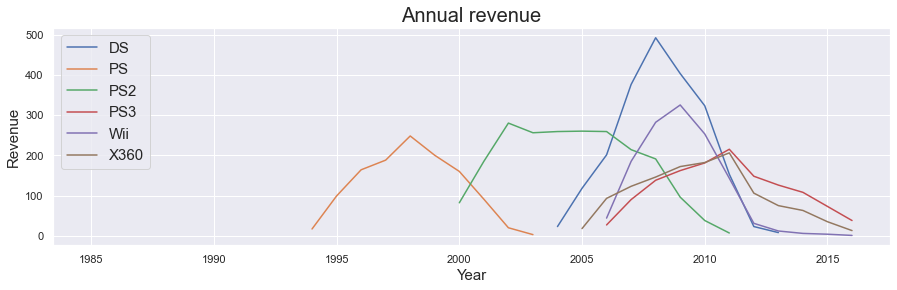

In [16]:
df_filtered = df[df['platform'].isin(top_6.index)]
df_filtered = df_filtered.pivot_table(
index='year_of_release', columns='platform', values='name', aggfunc='count')
plt.figure(figsize=(15,4))
plt.plot(df_filtered)
plt.title('Annual revenue', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Revenue', fontsize=15)
plt.legend(top_6.index, loc='upper left', fontsize=15)
plt.grid(True)
plt.show()

As we see, the mean period of console's life is about 10 years. It decreases year per year.

#### Actual Period
According to the information from previous observations, we will count the actual period from year 2013 (the difference at this point is much more critical).

In [17]:
df = df.query('year_of_release >= 2013')
df['platform'].unique()

array(['PS3', 'X360', 'PS4', '3DS', 'XOne', 'WiiU', 'Wii', 'PC', 'PSV',
       'DS', 'PSP'], dtype=object)

Let's plot the graphic for the certain period.

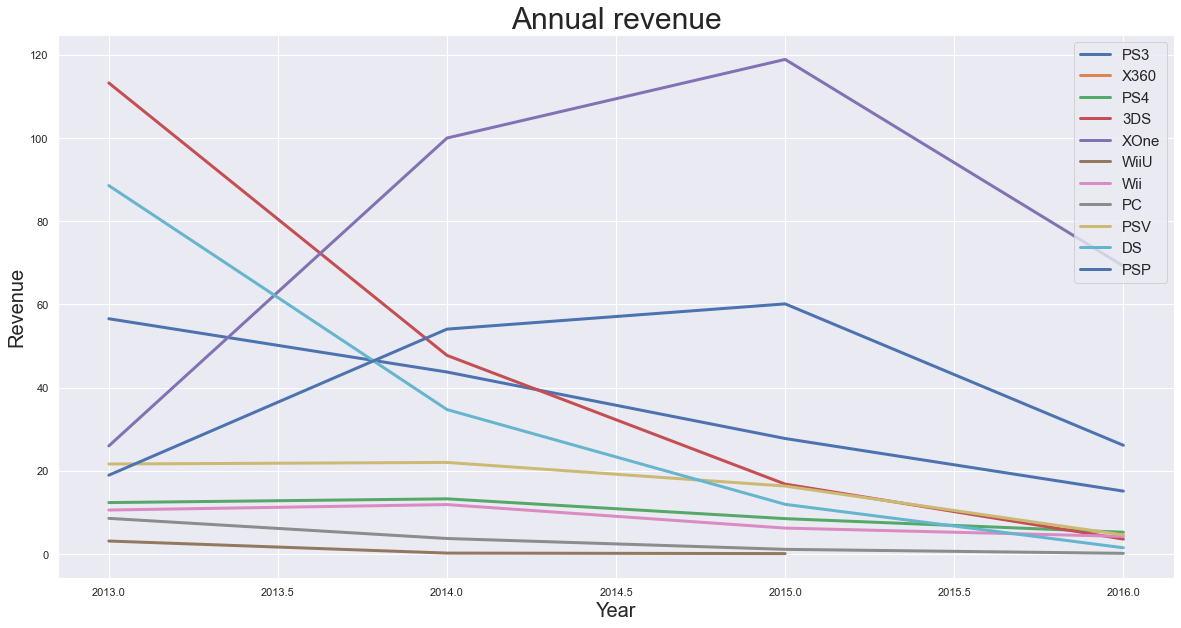

In [18]:
plat_actual = df.pivot_table(index='year_of_release', columns='platform',
values='total_sales', aggfunc='sum')
plt.figure(figsize=(20,10))
plt.plot(plat_actual, linewidth=3.0)
plt.title('Annual revenue', fontsize=30)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Revenue', fontsize=20)
plt.legend(['PS3', 'X360', 'PS4', '3DS', 'XOne',
'WiiU', 'Wii', 'PC', 'PSV','DS', 'PSP'], fontsize=15, loc=1)
plt.grid(True)
plt.show()

It is hard to predict any persprctives. Let's check the number of games per year.

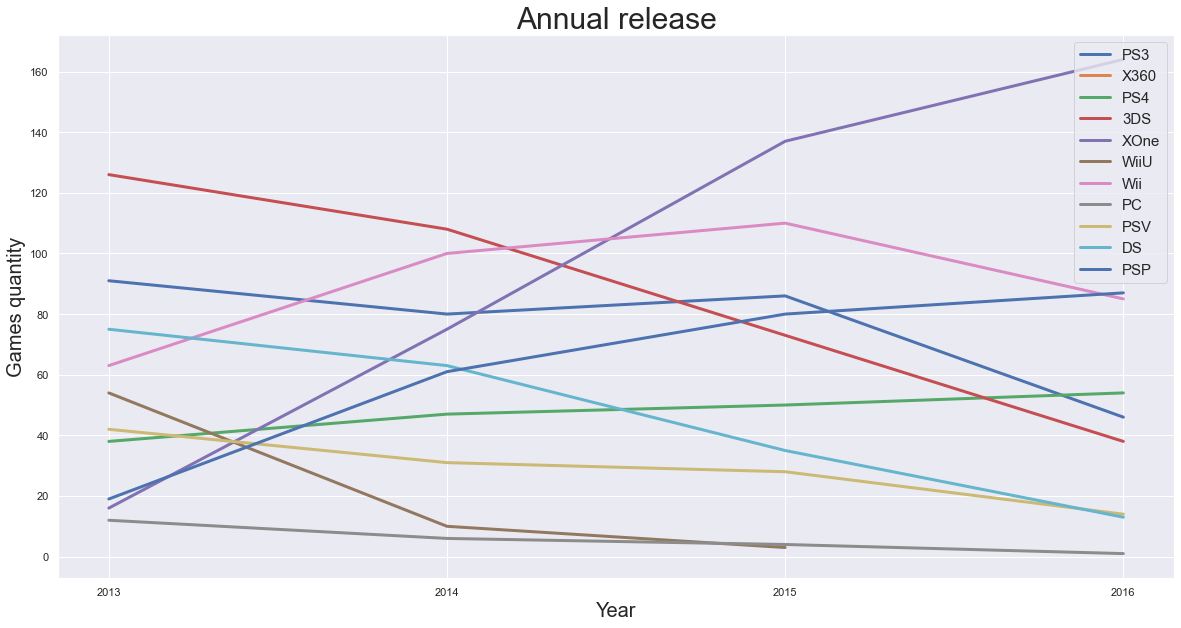

In [19]:
plat_actual = df.pivot_table(index='year_of_release', columns='platform',
values='name', aggfunc='count')
plt.figure(figsize=(20,10))
plt.plot(plat_actual, linewidth=3.0)
plt.title('Annual release', fontsize=30)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Games quantity', fontsize=20)
plt.legend(['PS3', 'X360', 'PS4', '3DS', 'XOne',
'WiiU', 'Wii', 'PC', 'PSV','DS', 'PSP'], fontsize=15, loc=1)
plt.xticks(np.arange(2013, 2017, step=1))
plt.grid(True)
plt.show()

We see XOne in leaders. We see the growth in XOne, PS3, PS4. All the other platforms are reducing their sales.

#### Sales analysis.

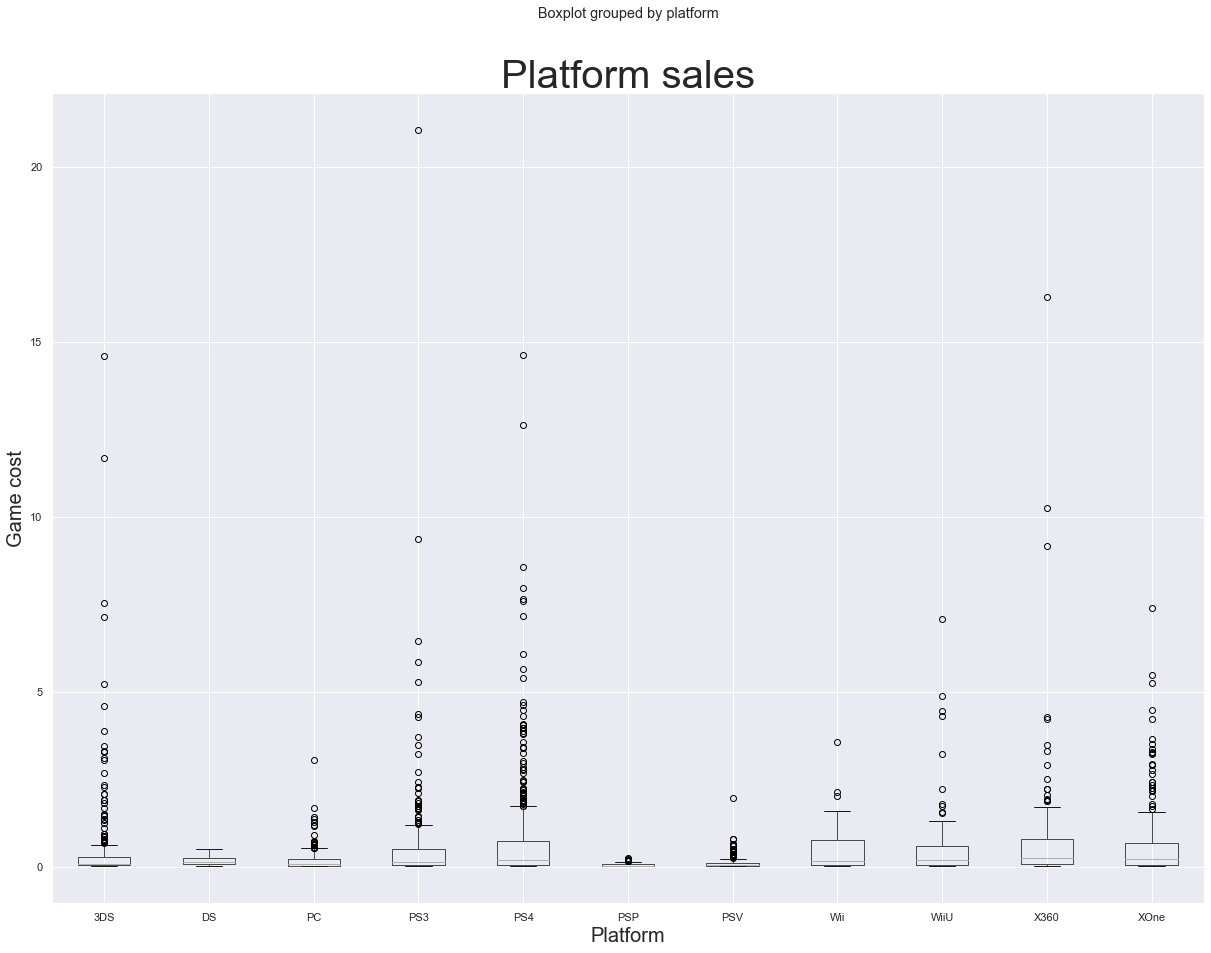

In [20]:
df.boxplot(column="total_sales", by="platform", figsize=(20, 15));
plt.title('Platform sales', fontsize=40)
plt.xlabel('Platform', fontsize=20)
plt.ylabel('Game cost', fontsize=20);

We see a lot of outlines. Let's limit `y` line.

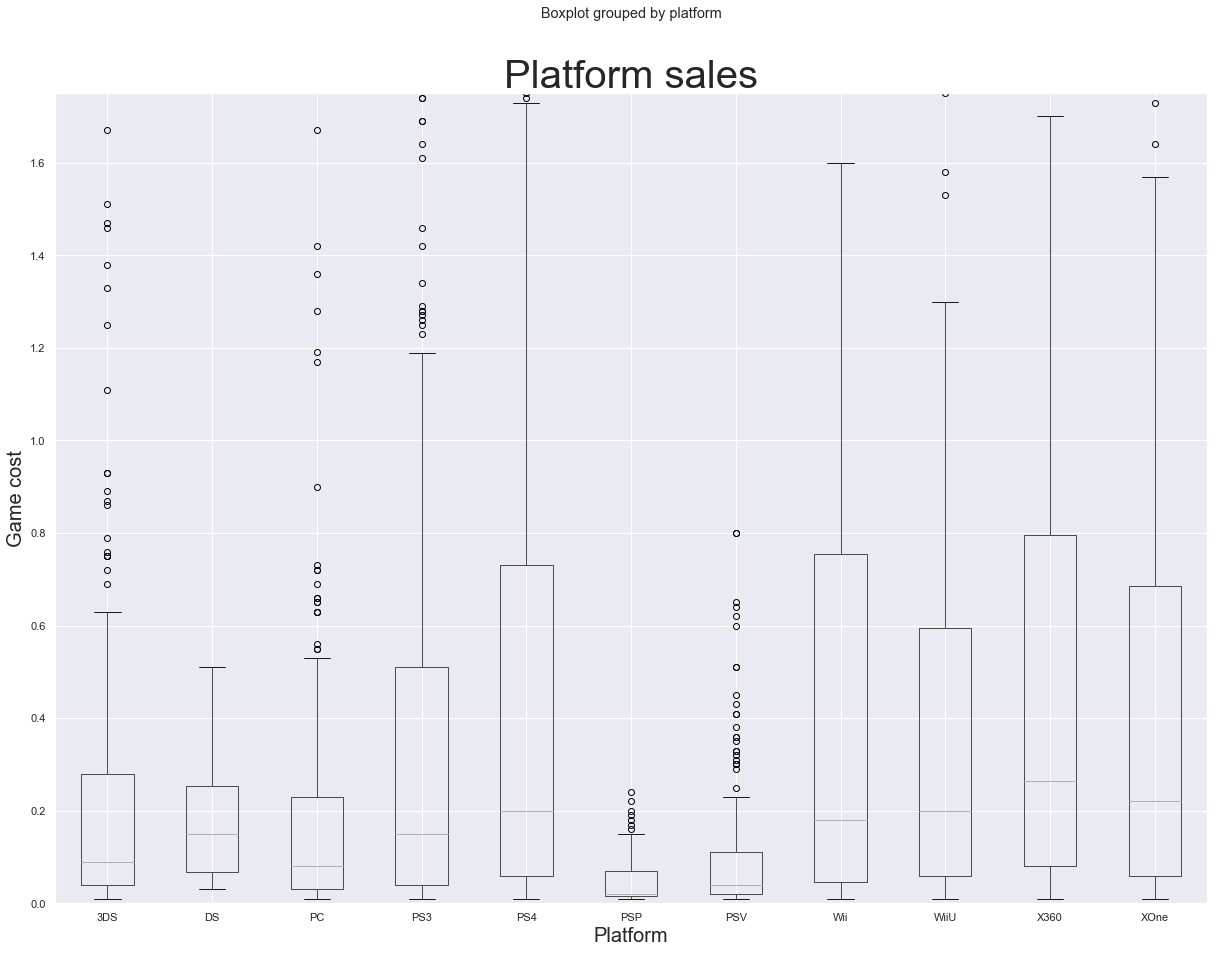

In [21]:
df.boxplot(column="total_sales", by="platform", figsize=(20, 15));
plt.title('Platform sales', fontsize=40)
plt.ylim(0,1.75)
plt.xlabel('Platform', fontsize=20)
plt.ylabel('Game cost', fontsize=20);

We see high cost spreading at PS3, PS4, Wii, WiiU, X360, XOne. Sales median is higher than 0.2 only at X360 and XOne. Almost all the mentioned consoles (except PS3) have slightly same spread between Q3 and Q4. We see that other platforms do not compete with the mentioned list. 

#### Critics analysis

In [22]:
#let's leave one platform
df_x360 = df[df['platform'] == 'X360']

##### Critics score.

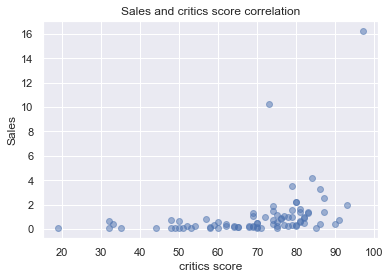

In [23]:
plt.scatter(df_x360['critic_score'],df_x360['total_sales'], alpha=0.5)
plt.title("Sales and critics score correlation")
plt.xlabel("critics score")
plt.ylabel("Sales")
plt.show()

We see very small correlation.

##### User score.

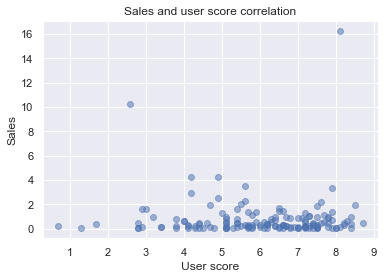

In [24]:
plt.scatter(df_x360['user_score'],df_x360['total_sales'], alpha=0.5)
plt.title("Sales and user score correlation")
plt.xlabel("User score")
plt.ylabel("Sales")
plt.show()

The correlation is quite small.

##### Common correlation

Let's check the common correlation.

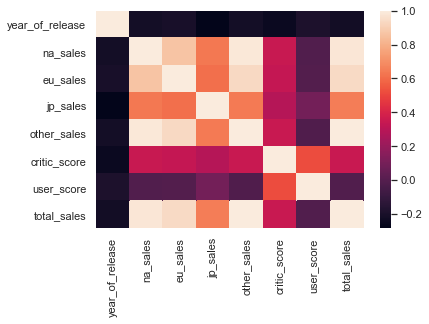

In [25]:
sns.heatmap(df_x360.corr());

As we expected, sales and user score correlation is close to 0. Critics score is correlated with sales a bit more.

#### Testing the conclusion at other platforms.

Let's test could we make the same conclusion at different platforms. Use some platforms and check the result.

In [26]:
#to simplify, get rid of columns that are not needed 
#and make a function that shows correlation depending on the platform
df_analysis= df[['platform','total_sales','critic_score','user_score']]
def analysis(name):
    ax = plt.axes()
    sns.heatmap(
    df_analysis[df_analysis['platform'] == name].corr(),
    vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', ax = ax)
    ax.set_title(name, fontsize=20)
    return plt.show()

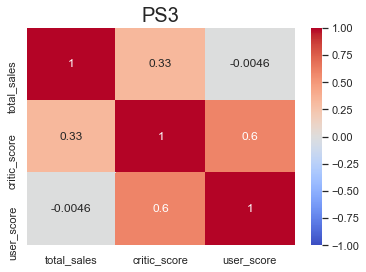

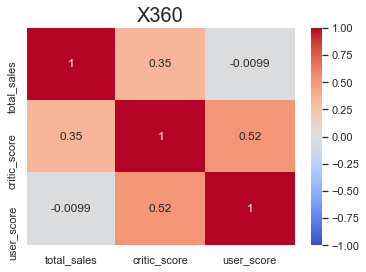

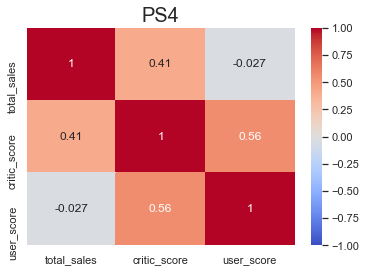

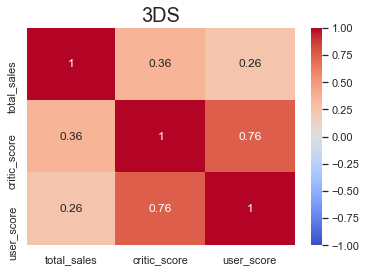

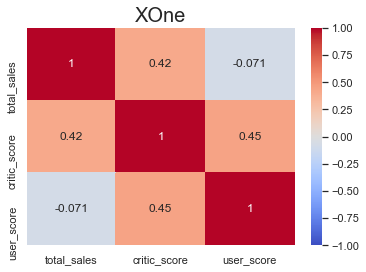

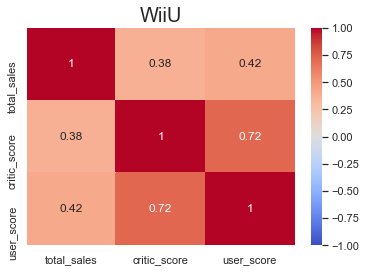

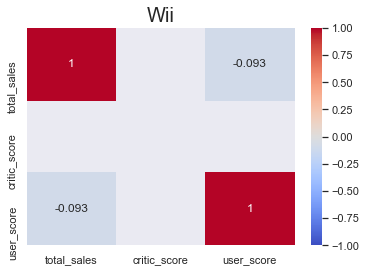

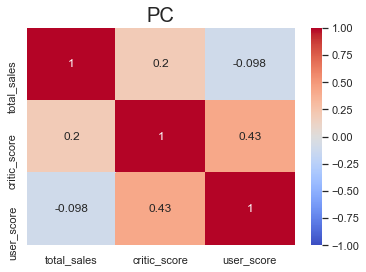

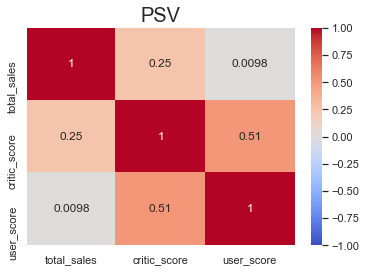

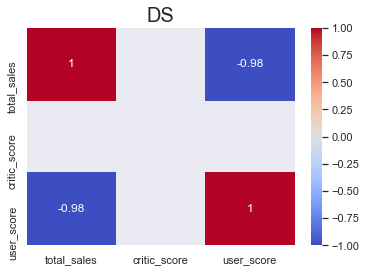

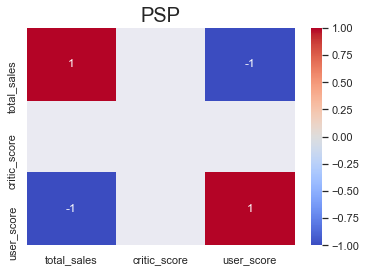

In [27]:
for i in df_analysis['platform'].unique():
    analysis(i)

Main conclusions:

1) PS3, PS4, X360, XOne and PC have high correlation with critic score (less for PC and PSV) and low with user score;

2) 3DS and WiiU have high correlation both with critic and user score;

3) DS and PSP have no data for critic score, but for user score they have very high negative correlation;

4) Wii have no data for critic score and almost no correlation with user score.

#### Most profit genres.

Let's check how the revenue is spreaded depending on games genre.

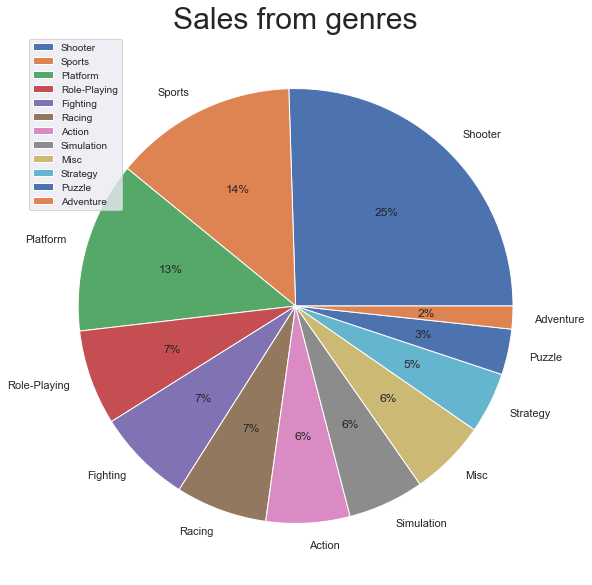

In [28]:
pie_genre = df.pivot_table(
index='genre', values='total_sales', aggfunc='median').reset_index().sort_values(by='total_sales',ascending=False)

plt.figure(figsize=(20,10))
plt.pie(pie_genre['total_sales'], labels = pie_genre['genre'], autopct='%1.0f%%')
plt.title('Sales from genres', fontsize=30)
plt.legend(pie_genre['genre'], fontsize=10, loc=2)
plt.show()

Shooter is the most profit genre. Then we see Sports, Platform and RPG. Most probably these games are easy to adapt for different platforms.

### Regional user portrait

In [29]:
#make a function for our plot
def pop(region, name):
    pie = df.pivot_table(
        index='platform', values=region, aggfunc='sum').reset_index().sort_values(by=region, ascending=False)    
    pie = pie[pie[region] > 10]
    plt.figure(figsize=(15,11))
    plt.pie(pie[region], labels = pie['platform'], autopct='%1.0f%%')
    plt.title(name, fontsize=20)
    plt.legend(title="Top platforms", loc='upper right')
    return plt.show()

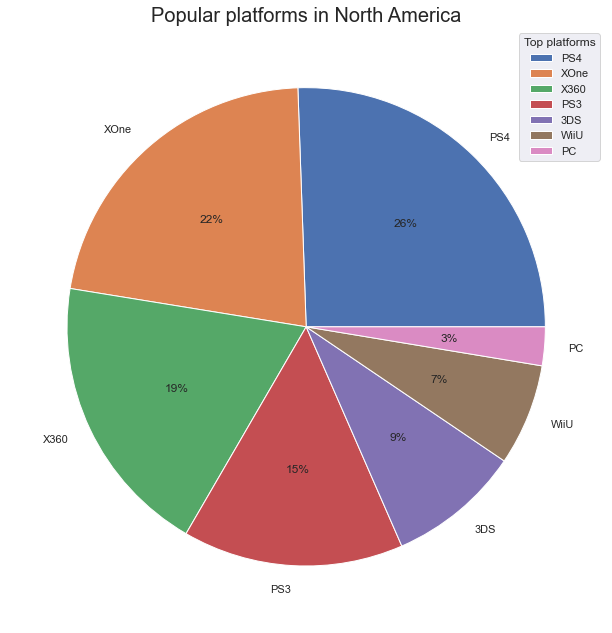

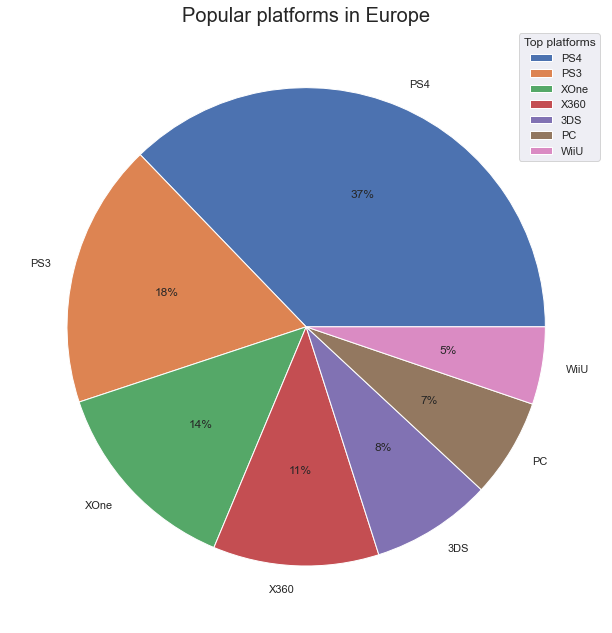

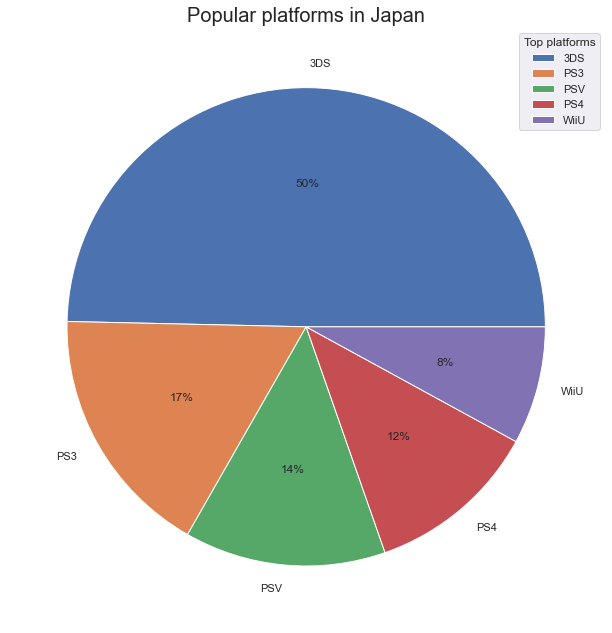

In [30]:
pop('na_sales', 'Popular platforms in North America')
pop('eu_sales', 'Popular platforms in Europe')
pop('jp_sales', 'Popular platforms in Japan')

According to our plots:

1) **USA**     PS4 (26%), XOne (22%), X360 (19%) and PS3 (15%);

2) **Europe**  PS4 (37%), PS3 (18%), XOne (14%) and X360 (11%);

3) **Japan**  3DS (50%), PS3 (17%), PSV (14%) and PS4 (12%).


Markets are vary depending on region. In USA and Europe PS4 is the most popular. In Japan the most popular platform is 3DS, most probably because it is mobile platform and can be used everywhere.

#### Genres

In [31]:
#make the function
def pop_genre(region, name):
    pie = df.pivot_table(
        index='genre', values=region, aggfunc='mean').reset_index().sort_values(by=region, ascending=False)
    pie = pie[pie[region] > 0.06]
    plt.figure(figsize=(15,10))
    plt.pie(pie[region], labels = pie['genre'], autopct='%1.0f%%')
    plt.title(name, fontsize=20)
    plt.legend(title="Top genres", loc='upper right')
    return plt.show()

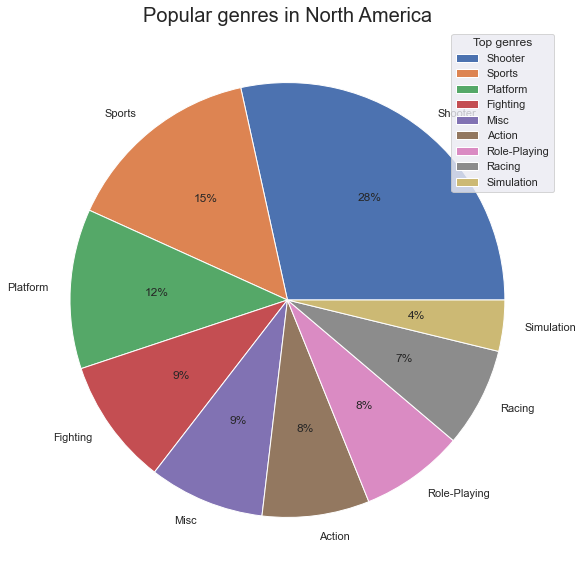

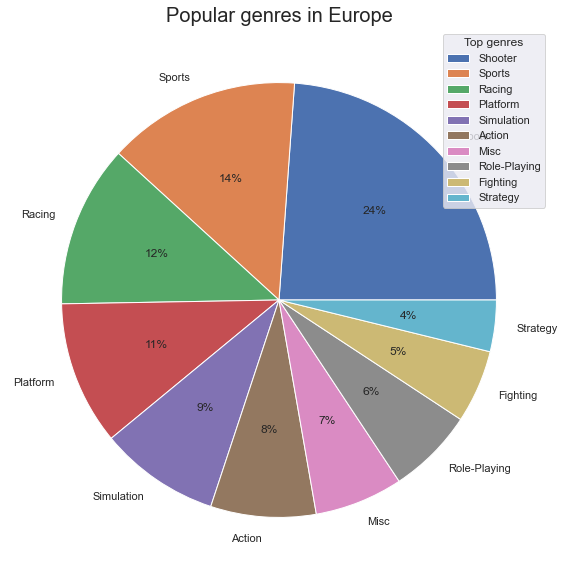

<ipython-input-31-098608666ff1>:7: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  plt.pie(pie[region], labels = pie['genre'], autopct='%1.0f%%')


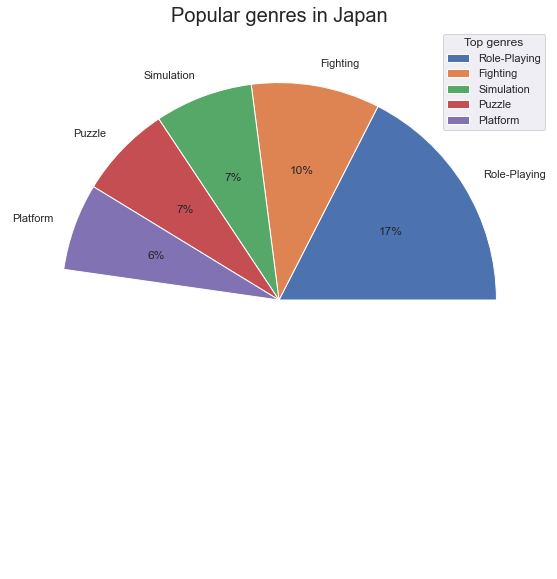

In [32]:
pop_genre('na_sales', 'Popular genres in North America');
pop_genre('eu_sales', 'Popular genres in Europe');
pop_genre('jp_sales', 'Popular genres in Japan');

Most popular genres are:

1) **USA** Shooter (28%), Sports (15%) and Platform (12%);

2) **Europe** Shooter (24%), Sports (14%) and Racing (12%);

3) **Japan** Role-Playing (17%), Fighting (10%) and Simulation (7%).

USA and Europe like Shooters and Sports games. This can also be correlated with most popular platforms in this region.
For Japan - RPG and Fighting, it can be correlated with the most popular platform in this region as well.

#### Rating.

In [33]:
def pop_rating(region, name):
    pie = df.pivot_table(
        index='rating', values=region, aggfunc='sum').reset_index().sort_values(by=region, ascending=False)
    plt.figure(figsize=(15,8))
    plt.pie(pie[region], labels = pie['rating'], autopct='%1.0f%%')
    plt.title(name, fontsize=20)
    plt.legend(title="Top rating", loc='upper right')
    return plt.show()

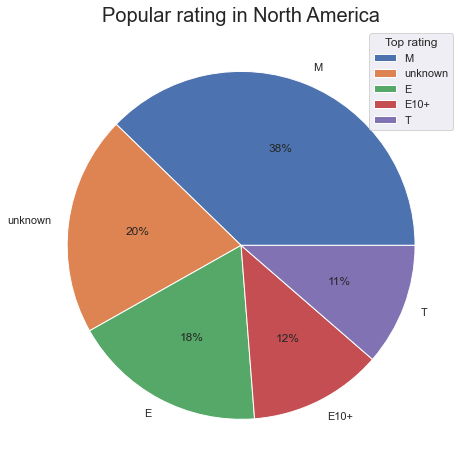

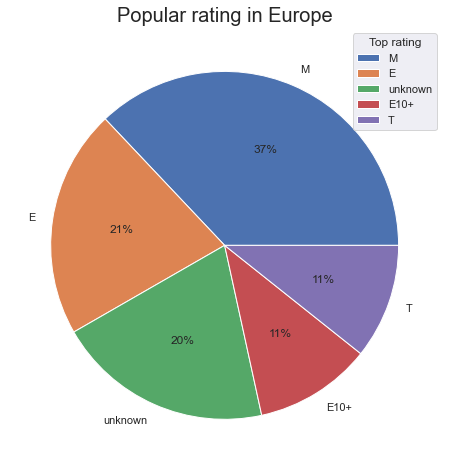

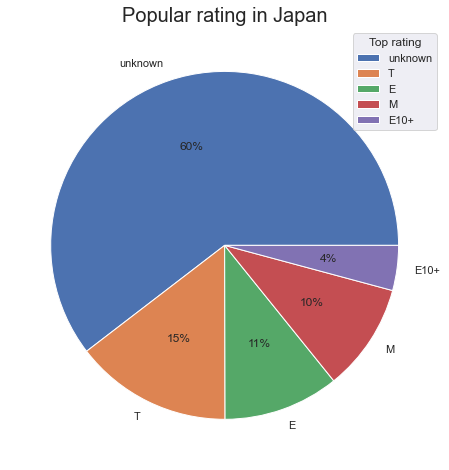

In [34]:
pop_rating('na_sales', 'Popular rating in North America')
pop_rating('eu_sales', 'Popular rating in Europe')
pop_rating('jp_sales', 'Popular rating in Japan')

In USA and Europe almost equally popular rating `M` (38% and 37%).
In Japan 60% of games don't have any rating, so we could assume that the rating doesn't play the key role in this region.

## A/B testing

### Comparison of Xbox One and PC mean user ratings 

1) Null hypothesis: mean user ratings of platform are equal.

2) Alternative hypothesis: mean user ratings of platform are different.

In [35]:
xone = df.query('platform == "XOne"')['user_score'].dropna()
pc = df.query('platform == "PC"')['user_score'].dropna()

Check all the main distribution parameters.

In [36]:
df.query('platform == ["XOne","PC"]').groupby("platform").user_score.agg(["count", "median", "mean", "std",'var'])

,count,median,mean,std,var
platform,,,,,
PC,156,6.8,6.282692,1.744343,3.042731
XOne,185,6.8,6.524865,1.372925,1.884922


Variations are not equal. Take it into account during our test.

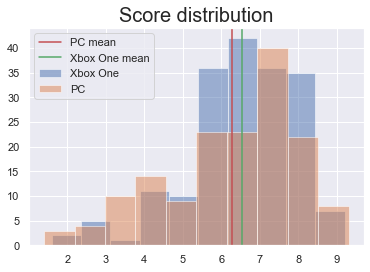

In [37]:
plt.hist(xone, alpha=0.5, label='Xbox One')
plt.hist(pc,  alpha=0.5, label='PC')
plt.axvline(x = pc.mean(), color = 'r', label = 'PC mean')
plt.axvline(x = xone.mean(), color = 'g', label = 'Xbox One mean')
plt.legend(loc='upper left')
plt.title('Score distribution', fontsize=20)
plt.show()

To compare means of two general populations. Let's use `ttest_ind`.

In [38]:
alpha = 0.05 

results = st.ttest_ind(
    xone, 
    pc, equal_var = False)

print('p-value: {:.2f} '.format(results.pvalue))

if results.pvalue < alpha:
    print("Reject the null hypothesis")
else:
    print("Failed to reject the null hypothesis") 

p-value: 0.16 
Failed to reject the null hypothesis


User rating doesn't depends on platform (in most cases).

### Comparison of user rating in Action and Sports genres.

1) Null hypothesis: mean user ratings of Action and Sports games are equal;

2) Alternative hypothesis: mean user ratings of Action and Sports games are not equal. 

In [39]:
action = df.query('genre == "Action"')['user_score'].dropna()
sports = df.query('genre == "Sports"')['user_score'].dropna()

Check all the main distribution parameters.

In [40]:
df.query('genre == ["Action","Sports"]').groupby("genre").user_score.agg(["count", "median", "mean", "std",'var'])

,count,median,mean,std,var
genre,,,,,
Action,408,7.10,6.806863,1.383103,1.912975
Sports,164,5.55,5.290854,1.812019,3.283413


Variations are not equal. Take it into account during our test.

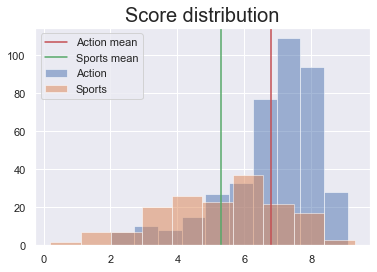

In [41]:
plt.hist(action, alpha=0.5, label='Action')
plt.hist(sports,  alpha=0.5, label='Sports')
plt.axvline(x = action.mean(), color = 'r', label = 'Action mean')
plt.axvline(x = sports.mean(), color = 'g', label = 'Sports mean')
plt.legend(loc='upper left')
plt.title('Score distribution', fontsize=20)
plt.show()

Compare means of two general populations. Use `ttest_ind`.

In [42]:
alpha = 0.05 

results = st.ttest_ind(action, sports, equal_var=False)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("Reject the null hypothesis")
else:
    print("Failed to reject the null hypothesis") 

p-value:  7.631940781789291e-19
Reject the null hypothesis


Differences with mean user score in Action and Sports genres are statisticaly significant.

## Conclusion.

**According to our research based on total sales sum, we could assume the following:**


1) Top sales platforms are: PS3, PS4, Wii, WiiU, X360, XOne;

2) Sales are reducing at all the platforms from 2013 to 2016;

3) We see high growth of new games at platforms XOne, PS3 and PS4. We could call these platforms perspective; 

All the above mentioned consoles have already reached their sales peak and slowly reducing their sales. So even perspective platforms have only 4-5 years.

**Market analysis**

At first we should mention that Japan market differ from Europe and USA market. Most probably it is caused by cultural differences.
1) USA and Europe:
 - `Shooter` and `Sports` genres are most popular;

 - Popular platform - `PS4`. Rating - `M`

2) Japan:
 - `RPG` and `Fighting` are most popular;
 
 - `Nintendo DS` is popular platform. Rating in not significant, because 60% of Japan market games doesn't have it.

**A/B test**

Test shows that most probably:
1) The platform type doesn't affect the user score;

2) We won't receive equal mean user score in different genres.